#                                         主题模型及其应用：       政府网站内容中的知识发现

## 1. 导入软件包

In [4]:
# 中文分词库，用于对中文文本进行分词处理
import jieba
# 数据处理和分析库，用于处理和分析数据
import pandas as pd
# Gensim库中的corpora和models模块，用于主题建模和文本处理
from gensim import corpora, models
# Scikit-learn库中的CountVectorizer，用于将文本转换为词频矩阵
from sklearn.feature_extraction.text import CountVectorizer
# 绘图库，用于数据可视化
import matplotlib.pyplot as plt
# 忽略警告信息
import warnings
warnings.filterwarnings('ignore', category=Warning)
# 数值计算库，用于数值运算
import numpy as np
# pyLDAvis库中的gensim_models模块，用于可视化LDA主题模型
import pyLDAvis.gensim_models 
# Gensim库中的CoherenceModel、LdaModel和Dictionary，用于计算主题一致性和LDA模型
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
# 中文显示支持，设置字体为SimHei
plt.rcParams['font.sans-serif'] = ['SimHei']
# BERTopic库，用于BERT主题建模
from bertopic import BERTopic
# Spacy库，用于自然语言处理，加载中文模型'zh_core_web_sm'
import spacy
nlp_model = spacy.load('zh_core_web_sm')

## 2.预处理函数定义

In [6]:
def remove_stopwords():
    """
    读取停用词文件，返回停用词列表
    """
    stop_word = [line.strip() for line in open('./data/stopwords.txt', 'r', encoding='utf-8')]
    return stop_word

words_dic = {}

def tongji(text, stopwords):
    """
    分词统计函数，对文本进行分词并统计词频
    """
    text = text.replace('\n', '').replace(' ', '').replace('\r', '').replace('\u3000', '')\
        .replace('\t', '').replace('\xa0', '').replace('\u2002', '')                            # 去除空格和换行符
    words = jieba.cut(text)                                                                     # 分词
    words = [str(w) for w in words if str(w) not in stopwords]                                  # 去除停用词
    for word in words:
        if word not in words_dic:
            words_dic[word] = 0
        words_dic[word] += 1
    return ' '.join(words)    

def tokenize(text, stopwords):                                                             # 分词函数
    """
    文本分词函数，对文本进行分词并返回连接后的字符串
    """
    text = text.replace('\n', '').replace(' ', '').replace('\r', '').replace('\u3000', '')\
        .replace('\t', '').replace('\xa0', '').replace('\u2002', '')
    words = jieba.cut(text)
    words = [str(w) for w in words if str(w) not in stopwords]
    return ' '.join(words)

def data_process(limit_min=1, limit_max=100):    # 数据预处理函数
    """
    数据预处理函数，读取数据、处理时间列、分词、去除低频和高频词，并返回处理后的数据框
    """
    stopwords = remove_stopwords()              # 读取停用词
    df = pd.read_excel("./data/国常会.xlsx")    # 读取数据

    # # 处理时间列
    # df['日期'] = pd.to_datetime(df['时间'], errors='coerce', format='%Y.%m.%d').combine_first(
    #     pd.to_datetime(df['时间'], errors='coerce', format='%Y-%m-%d')                              # 合并两种时间格式
    # )
    # df['year'] = df['日期'].dt.year
    # df['month'] = df['日期'].dt.month
    # df['day'] = df['日期'].dt.day
    
    # 应用tongji函数，统计词频
    df['统计'] = df['全文'].apply(tongji, args=(stopwords,))
    print(len(words_dic))
    
    # 剔除低频和高频词
    words_rm = [k for k, v in words_dic.items() if v <= limit_min or v >= limit_max]      # 剔除低频和高频词
    print(len(words_rm))                                                                  # 打印剔除词的数量
    del df["统计"]                                                                        # 删除统计列  
    stopwords = stopwords + words_rm
    stopwords = set(stopwords)
    print(len(stopwords))
    
    # 应用tokenize函数，进行分词
    df['content'] = df['全文'].apply(tokenize, args=(stopwords,))
    
    # 添加标签列
    di = {"国常会": 4, "江苏": 3, "陕西": 3, "安康": 2, "苏州": 2, "昆山": 1, "旬阳": 1, "张家港": 1}
    df["label"] = df["级别"].map(di)
    
    # 删除缺失值
    df.dropna(subset=["content"], inplace=True)
    
    # 打印处理后的数据框信息
    documents = df['content'].tolist()
    documents = [i.split(" ") for i in documents]
    print(max(len(sublist) for sublist in documents))
    
    return df


## 3. 数据读取与清洗模块

### data_process(limit_min=2,limit_max=50) 中的两个参数将出现次数过多或过少的词过滤

In [155]:
# 读取数据
df = data_process(limit_min=5,limit_max=50)
df.to_excel("./res/数据清洗.xlsx",index=False)
df 

27537
17239
19132
377


,Unnamed: 0,标题,时间,全文,级别,日期,year,month,day,content,label
0,0,李克强主持召开国务院常务会议 部署进一步抓好春季农业生产的措施 确保粮食丰收和重要农产品稳定...,2022.04.20,\n\n李克强主持召开国务院常务会议\n\n\n\n部署进一步抓好春季农业生产的措施 确保粮...,国常会,2022-04-20,2022,4,20,增供 日电 增供 稳定物价 压舱 石 粮食市场 通胀 尤为重要 粮食供应 充足 春播 播种面...,4
1,1,李克强主持召开国务院常务会议 部署促进消费的政策举措 助力稳定经济基本盘和保障改善民生 ...,2022.04.13,\n\n李克强主持召开国务院常务会议\n\n\n\n部署促进消费的政策举措 助力稳定经济基本...,国常会,2022-04-13,2022,4,13,日电 持久 拉动力 民航 水路 铁路运输 调运 托育 家电 限购 限购 县乡 依法惩治 欺诈...,4
2,2,李克强主持召开国务院常务会议 决定对特困行业实行阶段性缓缴养老保险费政策 加大失业保险支持稳...,2022.04.06,\n\n李克强主持召开国务院常务会议\n\n\n\n决定对特困行业实行阶段性缓缴养老保险费政...,国常会,2022-04-06,2022,4,6,缓缴 养老保险费 日电 缓缴 养老保险费 加剧 超出 复苏 放缓 波动 警觉 推 大盘 能源...,4
3,3,李克强主持召开国务院常务会议 要求压实责任落细措施 坚决防止重特大安全事故 部署用好政府债券...,2022.03.29,\n\n李克强主持召开国务院常务会议\n\n\n_x000D_\n要求压实责任落细措施 坚决...,国常会,2022-03-29,2022,3,29,板增 新开工 条件成熟 日电 板增 新开工 条件成熟 起立 东航 飞行 遇难 同胞 默哀 遇...,4
4,4,李克强主持召开国务院常务会议 确定实施大规模增值税留抵退税的政策安排 为稳定宏观经济大盘提供...,2022.03.21,\n\n\n李克强主持召开国务院常务会议\n\n\n\n确定实施大规模增值税留抵退税的政策安...,国常会,2022-03-21,2022,3,21,留抵 大盘 日电 留抵 大盘 留抵 1.5 涵养 税源 计税 留抵 全额 退还 微型 退还 ...,4
...,...,...,...,...,...,...,...,...,...,...,...
1584,1584,市政府召开2012年第六次常务会议,2012-07-02,7月2日上午，市长郭青主持召开市政府2012年第六次常务会议，研究确定了有关事项。\n\n\...,安康,2012-07-02,2012,7,2,郭青 第六次 旨在 透明度 东西 坝 东西 坝 一江 商业区 聚集区 就业机会 东西 坝 赢...,2
1585,1585,郭青主持召开市政府第五次常务会议,2012-06-01,6月1日，市长郭青主持召开市政府2012年第五次常务会议，研究确定了有关事项。\n\n\n\...,安康,2012-06-01,2012,6,1,郭青 备汛 洪水 水文 年份 偏多 局地 强降雨 引发 山洪 险情 形势严峻 放在首位 首长...,2
1586,1586,市政府常务会议首次邀请市民代表旁听,2012-06-01,6月1日，市政府2012年第五次常务会议如期举行。与以往不同的是，本次会议多了几名参会“嘉宾...,安康,2012-06-01,2012,6,1,以往 参会 嘉宾 王功辉 透明度 知情权 参与权 监督权 民主化 报纸 发布公告 自愿 报名...,2
1587,1587,郭青主持召开市政府第三次常务会议,2012-03-05,3月2日上午，市长郭青主持召开市政府2012年第三次常务会议，研究确定了有关事项。\n 会...,安康,2012-03-05,2012,3,5,郭青 超额完成 万套 廉租房 公 2600 限价 3000 扭转 不利 每季度 情况通报 告...,2


## 4、lda主题模型

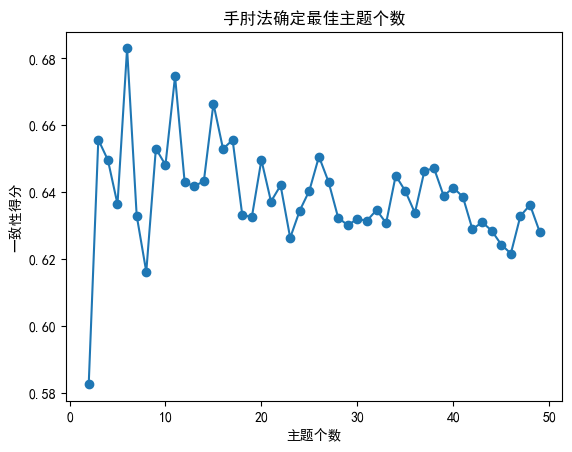

In [8]:
# 手肘法计算主题个数
max_topics = 50
documents = df['content'].tolist()
documents = [str(i).split(" ") for i in documents]
dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(words) for words in documents]
# 使用手肘法确定最佳主题个数
coherence_values = []
model_list = []
for num_topics in range(2, max_topics):  # 调整测试的主题个数范围
    lda_model = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
    model_list.append(lda_model)
    coherence_model = models.CoherenceModel(model=lda_model, texts=documents, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())
# 画出手肘法的曲线
x = range(2, max_topics)  # 主题个数范围
plt.plot(x, coherence_values, marker='o')
plt.xlabel("主题个数")
plt.ylabel("一致性得分")
plt.title("手肘法确定最佳主题个数")
plt.show()

In [9]:
# 计算主题
num_topics = 12 # 假设最佳主题个数
dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(words) for words in documents]
# lda模型，num_topics设置主题的个数
lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
# 打印所有主题，每个主题显示5个词
for topic in lda.print_topics(num_words=10):
    print(topic)

(4, '0.002*"保证金" + 0.002*"事业性" + 0.002*"民法典" + 0.002*"注销" + 0.002*"独角兽" + 0.001*"创业投资" + 0.001*"缴存" + 0.001*"试验" + 0.001*"保护法" + 0.001*"江南"')
(2, '0.002*"吴淞江" + 0.002*"功能区" + 0.002*"浪费" + 0.002*"公务用车" + 0.002*"小镇" + 0.002*"自贸区" + 0.002*"造林" + 0.001*"孵化器" + 0.001*"保险费率" + 0.001*"地图"')
(29, '0.003*"中关村" + 0.002*"农户" + 0.002*"见义勇为" + 0.002*"功能区" + 0.002*"资本金" + 0.002*"保证金" + 0.002*"税率" + 0.002*"浪费" + 0.002*"科技人才" + 0.002*"营业税"')
(6, '0.003*"民宿" + 0.002*"医生" + 0.002*"创业投资" + 0.002*"整顿" + 0.001*"转让" + 0.001*"科技人员" + 0.001*"行政复议" + 0.001*"未成年人" + 0.001*"○" + 0.001*"数"')
(1, '0.002*"气化" + 0.002*"奶粉" + 0.002*"医生" + 0.002*"婴幼儿" + 0.002*"艺术" + 0.002*"全科" + 0.001*"县区" + 0.001*"困境" + 0.001*"账款" + 0.001*"管廊"')
(20, '0.003*"老人" + 0.003*"测绘" + 0.002*"每人" + 0.002*"每月" + 0.002*"三中全会" + 0.002*"岁" + 0.002*"基础科学" + 0.002*"地震" + 0.002*"牛蹄" + 0.002*"小组会议"')
(11, '0.002*"氢能" + 0.002*"老区" + 0.002*"地质" + 0.001*"协助" + 0.001*"本级" + 0.001*"资料" + 0.001*"涉嫌" + 0.001*"基础教育" + 0.001*"品种" + 0.001*"定价"')
(8, '0.003*"合作

In [10]:
# 保存到本地
df_temp2 = df.copy()
# # 为每个文档提取主题、词汇和概率，并添加到 DataFrame 中
# df_temp2['topic'] = [topic[0] for topic in topics_info]
# df_temp2['topic_words'] =  [lda.show_topic(topic[0][0]) for topic in top_topics]
# df_temp2['topic_probability'] = [topic for topic in topics_info]
df_temp2['lda_topic'] = df_temp2['content'].apply(lambda x: lda[dictionary.doc2bow(x.split())])
df_temp2[['topic', 'probability']] = pd.DataFrame(df_temp2['lda_topic'].apply(lambda x: max(x, key=lambda item: item[1])).tolist(), index=df.index)
df_temp2['topic_words'] = df_temp2['lda_topic'].apply(lambda x: [word for word, prob in lda.show_topic(max(x, key=lambda item: item[1])[0])])

# 将修改后的 DataFrame 保存到 Excel 文件
df_temp2.to_excel("./res/output_lda.xlsx", index=False)

In [11]:
# 可视化
# 用pyLDAvis将LDA模式可视化
plot =pyLDAvis.gensim_models.prepare(lda,corpus,dictionary)
# 保存到本地html
pyLDAvis.save_html(plot, './res/pyLDAvis.html')

#notebook中显示
pyLDAvis.display(plot)

## 5、hdp主题模型

In [12]:
import pandas as pd
from gensim.corpora import Dictionary
import gensim

In [13]:
tokenized_data = df['content'].tolist()
tokenized_data = [i.split(" ") for i in tokenized_data]
# print(tokenized_data)
# 创建字典和语料库
dictionary = Dictionary(tokenized_data)
corpus = [dictionary.doc2bow(text) for text in tokenized_data]
# 使用HDP模型进行主题建模
hdp_model = gensim.models.hdpmodel.HdpModel(corpus=corpus, id2word=dictionary)

# 输出主题概率和主题词
topics = hdp_model.show_topics(num_topics=1000, num_words=10)
for topic_id, topic in topics:
    print(f"Topic {topic_id}: {topic}")

Topic 0: 0.003*库区 + 0.003*烟花爆竹 + 0.002*禁放 + 0.002*段 + 0.002*二级 + 0.001*资源整合 + 0.001*安岚 + 0.001*普惠小微 + 0.001*过境 + 0.001*镇村
Topic 1: 0.003*腾退 + 0.003*交通枢纽 + 0.002*议事 + 0.002*科创 + 0.002*十件 + 0.001*一策 + 0.001*扶 + 0.001*资源整合 + 0.001*放出 + 0.001*涉水
Topic 2: 0.004*采矿 + 0.004*采砂 + 0.003*江河湖泊 + 0.003*水源 + 0.002*南水北调 + 0.002*守水 + 0.002*稿 + 0.001*计生 + 0.001*农机 + 0.001*家政
Topic 3: 0.003*国有土地 + 0.002*涉嫌 + 0.001*江南 + 0.001*群众观点 + 0.001*套 + 0.001*机器人 + 0.001*建平 + 0.001*万平方米 + 0.001*本级 + 0.001*报送
Topic 4: 0.005*老人 + 0.004*方玮峰 + 0.003*每人 + 0.003*每月 + 0.003*岁 + 0.003*班子成员 + 0.002*新一届 + 0.002*保健 + 0.002*岭 + 0.002*高龄
Topic 5: 0.002*龙头 + 0.002*面源 + 0.001*计量 + 0.001*销售价格 + 0.001*监事会 + 0.001*立方米 + 0.001*马晓旬 + 0.001*寄递 + 0.001*第六次 + 0.001*退捕
Topic 6: 0.002*决不能 + 0.002*青年 + 0.001*人工智能 + 0.001*职业院校 + 0.001*华江 + 0.001*购置税 + 0.001*六要 + 0.001*征兵 + 0.001*照护 + 0.001*生产总值
Topic 7: 0.003*南水北调 + 0.003*复星 + 0.003*垃圾处理 + 0.002*产业基地 + 0.002*生物 + 0.002*高技术 + 0.002*省上 + 0.002*涵养 + 0.002*廉租 + 0.002*水源
Topic 8: 0.001*努力争取 + 0.

In [14]:
# 保存到本地
# 提取每个文档的主题、对应的主题词和主题概率
topics_info = []
for i, doc in enumerate(corpus):
    topics_info.append(hdp_model[doc])
top_topics = [(max(topic, key=lambda x: x[1]), i) for i, topic in enumerate(topics_info)]
df_res = df.copy()
# 为每个文档提取主题、词汇和概率，并添加到 DataFrame 中
df_res['topic'] = [topic[0][0] for topic in top_topics]
df_res['topic_words'] = [hdp_model.show_topic(topic[0][0]) for topic in top_topics]
df_res['topic_probability'] = [topic[0][1] for topic in top_topics]

# 将修改后的 DataFrame 保存到 Excel 文件
df_res.to_excel("./res/output_hdp.xlsx", index=False)

## 6、SLDA有监督半监督主题模型

In [16]:
import tomotopy as tp
 
def find_k(docs, min_k=1, max_k=20, min_df=2):
    scores = []
    for k in range(min_k, max_k):
        slda = tp.SLDAModel(k=k, vars=['l'])
        for doc, label in zip(df['content'], df['label']):
            words = doc.split() if isinstance(doc, str) else doc
            slda.add_doc(words, y=[label])  
        slda.train(100)
        coh = tp.coherence.Coherence(slda)
        scores.append(coh.get_score())
 
    plt.plot(range(min_k, max_k), scores)
    plt.xlabel("number of topics")
    plt.ylabel("coherence")
    plt.show()

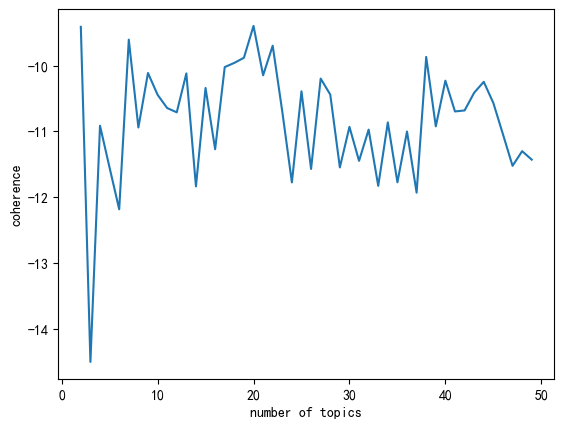

In [17]:
# 计算主题个数
find_k(docs=df['content'], min_k=2, max_k=50, min_df=2)

In [19]:
import tomotopy as tp
num_topics = 20 # 假设最好的类别个数
label_mapping = {label: idx for idx, label in enumerate(df['label'].unique())}
df['label'] = df['label'].map(label_mapping).astype(int)

slda = tp.SLDAModel(k=num_topics, vars=['l'])
for doc, label in zip(df['content'], df['label']):
    words = doc.split() if isinstance(doc, str) else doc
    slda.add_doc(words, y=[label])  
slda.train(100)
for k in range(slda.k):
    print('主题 #{} 的前20个词'.format(k))
    print(slda.get_topic_words(k, top_n=20))
    print()

主题 #0 的前20个词
[('传统产业', 0.006421998608857393), ('利用外资', 0.00589786097407341), ('十项', 0.005766826681792736), ('信息技术', 0.005635791923850775), ('考评', 0.0051116542890667915), ('硬', 0.00498061953112483), ('禁捕', 0.004849585238844156), ('普查', 0.004718550946563482), ('明确要求', 0.004718550946563482), ('回升', 0.004587516188621521), ('核算', 0.004456481896340847), ('管护', 0.004456481896340847), ('退捕', 0.004456481896340847), ('生产总值', 0.004325447604060173), ('呈现', 0.004194412846118212), ('决定性', 0.004194412846118212), ('趋势', 0.004194412846118212), ('主动权', 0.004194412846118212), ('见义勇为', 0.004063378553837538), ('清查', 0.004063378553837538)]

主题 #1 的前20个词
[('碳', 0.006352708209306002), ('自然灾害', 0.006352708209306002), ('关爱', 0.006076563615351915), ('汽车产业', 0.005524274427443743), ('盲区', 0.005110057070851326), ('管网', 0.004971984773874283), ('管理体系', 0.004971984773874283), ('重特大', 0.00483391247689724), ('光伏', 0.0046958401799201965), ('死角', 0.0046958401799201965), ('特种设备', 0.0046958401799201965), ('碳达峰', 0.004557767

In [23]:
slda.summary()

<Basic Info>
| SLDAModel (current version: 0.12.5)
| 1548 docs, 137500 words
| Total Vocabs: 11858, Used Vocabs: 11858
| Entropy of words: 9.03579
| Entropy of term-weighted words: 9.03579
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 100, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -9.00307
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 0 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 20 (the number of topics between 1 ~ 32767)
| vars: linear
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| mu: [] (mean of regression coefficients, default value is 0)
| nu_sq: [] (variance of regression coefficients, default value is 1)
| gl

In [24]:
# 保存到本地
# 添加三列用于保存计算结果
df_temp3 = df.copy()
df_temp3.dropna(subset=["content"], inplace=True)
print(len(df_temp3))
topic_list = []
top_words_list = []
topic_prob_list = []
for doc in df_temp3['content']:
    try:
        words = doc.split() if isinstance(doc, str) else doc
        #构造tomotopy需要的数据
        doc_inst = slda.make_doc(words=words)
        topic_dist, ll = slda.infer(doc_inst)
        dominant_topic = max(enumerate(topic_dist), key=lambda x: x[1])[0]
        top_words = slda.get_topic_words(dominant_topic, top_n=20)
        topic_list.append(dominant_topic)
        top_words_list.append(top_words)
#         topic_prob_list.append(topic_dist[dominant_topic])
        topic_prob_list.append([str(f"{i}:{topic_dist[i]}")  for i in range(len(topic_dist))])
    except:
        topic_list.append("")
        top_words_list.append("")
        topic_prob_list.append("")
df_temp3['Dominant_Topic'] = topic_list
df_temp3['Top_Words'] = top_words_list
df_temp3['Topic_Probability'] = topic_prob_list
# 保存 DataFrame 到 Excel 文件
df_temp3.to_excel('./res/output_slda.xlsx', index=False)

1589


In [25]:
# 可视化
#在notebook显示
pyLDAvis.enable_notebook()

#获取pyldavis需要的参数
topic_term_dists = np.stack([slda.get_topic_word_dist(k) for k in range(slda.k)])
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in slda.docs])
doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
doc_lengths = np.array([len(doc.words) for doc in slda.docs])
vocab = list(slda.used_vocabs)
term_frequency = slda.used_vocab_freq


prepared_data = pyLDAvis.prepare(
    topic_term_dists, 
    doc_topic_dists, 
    doc_lengths, 
    vocab, 
    term_frequency,
    start_index=0, # tomotopy话题id从0开始，pyLDAvis话题id从1开始
    sort_topics=False #注意：否则pyLDAvis与tomotopy内的话题无法一一对应。 
)
#可视化结果存到html文件中
pyLDAvis.save_html(prepared_data, './res/sldavis.html')

#notebook中显示
pyLDAvis.display(prepared_data)

## 7、 BERTopic主题模型

In [221]:
zh_model = spacy.load("zh_core_web_sm")

topic_model = BERTopic(language="chinese (simplified)", 
                       embedding_model=zh_model,
                       calculate_probabilities=True,
                       verbose=True,
                       min_topic_size = 2,
                       nr_topics=50,
                       top_n_words = 10)

docs = df['content'].tolist()
topics, probs = topic_model.fit_transform(docs)

100%|██████████████████████████████████████████████████████████████████████████████| 1589/1589 [00:22<00:00, 71.26it/s]
2023-11-30 03:53:03,994 - BERTopic - Transformed documents to Embeddings
2023-11-30 03:53:09,355 - BERTopic - Reduced dimensionality
2023-11-30 03:53:09,596 - BERTopic - Clustered reduced embeddings
2023-11-30 03:53:09,722 - BERTopic - Reduced number of topics from 6 to 6


In [222]:
df['日期字符串'] = df['日期'].dt.strftime('%Y/%m/%d')
timestamps= df['日期字符串'].to_list()
timestamps[:4]

['2022/04/20', '2022/04/13', '2022/04/06', '2022/03/29']

In [223]:
topics_over_time = topic_model.topics_over_time(docs, timestamps,nr_bins=10)

10it [00:00, 48.02it/s]


In [224]:
topic_model.visualize_topics_over_time(topics_over_time)

In [225]:
topic_model.visualize_topics_over_time(topics_over_time, topics=[1, 3, 4, 5, 6, 17])

## topic_model.get_topic_info 查看各主题信息

## topic_model.find_topics(term, top_n=5)  查找term最有可能所属话题

## topic_model.get_topic(0) 查看Topic 0的特征词

## topic_model.visualize_topics() 话题间距离的可视化

## topic_model.visualize_distribution(probs[0]) 查看某条文本的主题分布

## topic_model.visualize_hierarchy(top_n_topics=20) 主题层次聚类可视化

## topic_model.visualize_barchart(top_n_topics=6) 主题词条形图可视化

## topic_model.visualize_heatmap(n_clusters=10) 主题相似度热力图

## topic_model.visualize_term_rank() 可视化选择词语数量 三个还是四个还是两个

## topic_model.save()  保存主题模型

In [226]:
print(topic_model.get_topic_info())

   Topic  Count             Name  \
0     -1      1       -1_2006___   
1      0   1473  0_90_40_关注度_所得额   
2      1     78            1____   
3      2     15  2_2005_2007_74_   
4      3     12    3_2003_2006__   
5      4     10  4_2006_2004_38_   

                                 Representation  \
0                      [2006, , , , , , , , , ]   
1  [90, 40, 关注度, 所得额, 妇女儿童, 对表, 海绵, 干线, 造林, 艺术]   
2                          [, , , , , , , , , ]   
3                [2005, 2007, 74, , , , , , , ]   
4                  [2003, 2006, , , , , , , , ]   
5                [2006, 2004, 38, , , , , , , ]   

                                 Representative_Docs  
0                                             [2006]  
1  [77 表 明细表 常设机构 入医 促进法 表 明细表 表 明细表 精心策划 办实 当年度 ...  
2                                             [, , ]  
3                                 [2005, 2005, 2005]  
4                                 [2003, 2003, 2003]  
5                                 [2006, 2006, 2006]  


In [227]:
topic_model.get_topic(2)

[('2005', 3.403796096401651),
 ('2007', 2.9466041400872784),
 ('74', 0.525422220351978),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05)]

In [228]:
topic_model.visualize_topics()

In [229]:
topic_model.visualize_distribution(probs[11])

In [230]:
topic_model.visualize_hierarchy(top_n_topics=50)

In [231]:
topic_model.visualize_barchart(top_n_topics=10, width = 200, height= 200)

In [232]:
topic_model.visualize_heatmap(n_clusters=3, width=1000, height=1000,top_n_topics=20)